In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip show keras

Name: keras
Version: 2.11.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: keras-vis, tensorflow


In [ ]:
import numpy as np 
import pandas as pd
from numpy import load

import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras
import time, cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools

from sklearn import metrics

import seaborn as sns

In [ ]:
#chargement de X_brain et y_brain
np.load.__defaults__=(None, True, True, 'ASCII')

#X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_256.npy')
#y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')

# Shape de X_brain et y_brain
#print('Shape of X:', X_brain.shape)
#print('Shape of y:',y_brain.shape)

X_train = load('/content/drive/My Drive/Colab_outputs/X_train_lenet.npy')
y_train = load('/content/drive/My Drive/Colab_outputs/y_train_lenet.npy')
X_test = load('/content/drive/My Drive/Colab_outputs/X_test_lenet.npy')
y_test = load('/content/drive/My Drive/Colab_outputs/y_test_lenet.npy')
indices_test = load('/content/drive/My Drive/Colab_outputs/indices_test_lenet.npy')


In [ ]:
### split des données ###

#X_train, X_test, y_train, y_test = train_test_split(X_brain, y_brain, test_size=0.2, random_state=123)

# Shape de X_train et y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)

Shape of X: (2000, 150, 150, 3)
Shape of y: (2000,)


In [ ]:
# valeurs comprises entre 0 et 1 et transformation en vecteurs catégoriels binaires

X_train = X_train/255
X_test = X_test/255

In [ ]:
## Réseau de Neurones Convolutif LeNet5

inputs = Input(shape = X_train[0,...].shape)
layer1 = Conv2D(filters = 30, kernel_size = (5, 5), padding = 'valid', activation = 'relu')
layer2 = MaxPooling2D(pool_size=(2,2))
layer3 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu')
layer4 = MaxPooling2D(pool_size=(2,2))
layer5 = Dropout(rate = 0.2)
layer6 = Flatten()
layer7 = Dense(units=128, activation = 'relu')
output_layer = Dense(units=1, activation = 'sigmoid')

x = layer1(inputs)
x = layer2(x)
x = layer3(x)
x = layer4(x)
x = layer5(x)
x = layer6(x)
x = layer7(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 25

# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.001,
                    mode = 'min',
                    patience = 5,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 5,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

# save the best model
checkpoint_filepath = '/content/drive/My Drive/Colab_outputs/tmp/checkpoint'

model_checkpoint = ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

training_history_lenet = model.fit(X_train, 
                                   y_train, 
                                   epochs = EPOCHS, 
                                   batch_size = 200, 
                                   validation_split = 0.2, 
                                   callbacks=[reduce_learning_rate, early_stopping],
                                   class_weight=class_weights)

# The model weights (that are considered the best) are loaded into the model
#model.load_weights(checkpoint_filepath)

Epoch 1/25
8/8 [==============================] - 35s 4s/step - loss: 0.6960 - accuracy: 0.7125 - val_loss: 0.4194 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - 35s 5s/step - loss: 0.4873 - accuracy: 0.7219 - val_loss: 0.4262 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - 33s 4s/step - loss: 0.3848 - accuracy: 0.8156 - val_loss: 0.4991 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/25
8/8 [==============================] - 34s 4s/step - loss: 0.3175 - accuracy: 0.8537 - val_loss: 0.4751 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 5/25
8/8 [==============================] - 32s 4s/step - loss: 0.2518 - accuracy: 0.8775 - val_loss: 0.3752 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 6/25
8/8 [==============================] - 34s 4s/step - loss: 0.1875 - accuracy: 0.9081 - val_loss: 0.2446 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 7/25
8/8 [==============================] - 33s 4s/step - loss: 0.1361 - accuracy: 0.932

In [ ]:
model.save('/content/drive/My Drive/Colab_outputs/Lenet-BC-Last.h5')

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/Colab_outputs/Lenet-BC.h5')

In [ ]:
#from joblib import dump, load

# Enregistrement du modèle (à faire après l'entraînement)
#dump(model, '/content/drive/My Drive/Colab_outputs/Lenet-BC.joblib') 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 30)      2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 16)        4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 35, 35, 16)        0     

In [ ]:
#prediction 
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

16/16 [==============================] - 3s 204ms/step


In [ ]:
test_pred_array = np.array(test_pred_class)

In [ ]:
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,424,17
1,9,51


In [ ]:
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
print(classification_report_imbalanced(y_test,test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.96      0.85      0.97      0.90      0.83       441
          1       0.75      0.85      0.96      0.80      0.90      0.81        60

avg / total       0.95      0.95      0.86      0.95      0.90      0.82       501



In [ ]:
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']
train_loss = training_history_lenet.history['loss']
val_loss = training_history_lenet.history['val_loss']

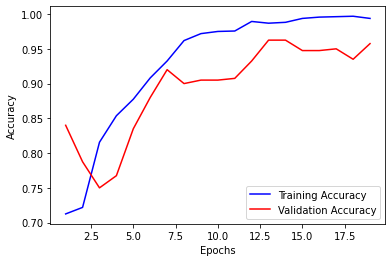

In [ ]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(train_acc)+1, 1),
         train_acc,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , len(val_acc)+1, 1),
         val_acc, 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
#prediction 
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

16/16 [==============================] - 3s 180ms/step


In [ ]:
#X_mask = load('/content/drive/My Drive/Colab_outputs/X_mask_150.npy')
#print('Shape of X_mask_150:',X_mask.shape)

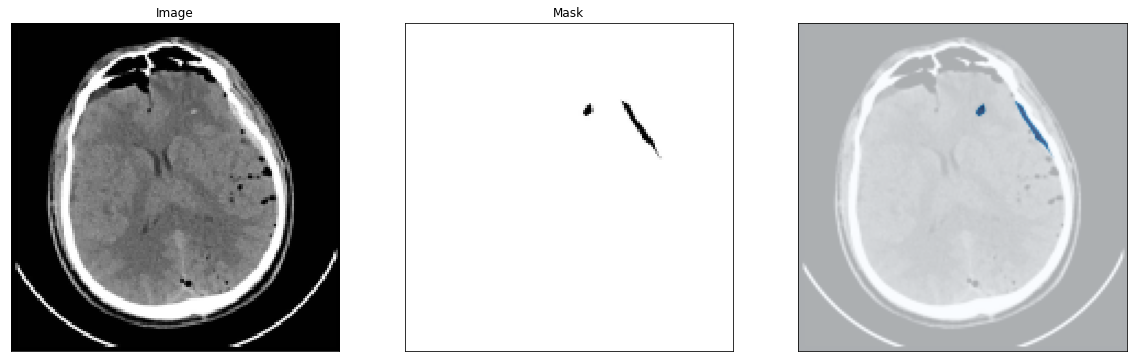

In [ ]:
from numpy import load

last_conv_layer_name = "conv2d_1"

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_150.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')
X_mask= load('/content/drive/My Drive/Colab_outputs/X_mask_150.npy')

# affichage d'une image aléatoire avec hémorragie
from random import randint

img = X_brain[y_brain == 1][5]
mask = X_mask[y_brain == 1][5]
#plt.imshow(img[randint(0,len(img))],cmap = cm.binary, interpolation='None')


# affichage des images côte à côte
fig = plt.figure(figsize = (20,20))

fig.add_subplot(1,3,1)
plt.imshow(img,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Image')

fig.add_subplot(1,3,2)
plt.imshow(mask,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.imshow(mask, cmap='Blues', alpha=0.7)

plt.show();

In [ ]:
#algorithme de Grad CAM

def get_img_array(img):
    # `img` is a PIL image of size 299x299
    #img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(img, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 60ms/step
Predicted: 0


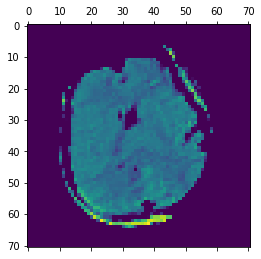

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", np.argmax(preds[0]))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


# Display heatmap
plt.matshow(heatmap)
plt.show()

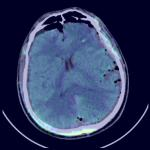

In [ ]:
from tensorflow import keras
from IPython.display import Image, display

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(150 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=150))


save_and_display_gradcam(img, heatmap)